# Modeling Approaches and Considerations

Now that we've gone through the extensive process of finding, exploring, annotating, and curating our datasets - we're ready to start the modeling process.

In this notebook, we're going to go through three main approaches:
1. Rule-based approach
2. Machine learning approach
3. GenAI: RAG Approach

<br/>

In each case, we will levereage the best practices discussed in the book, including:
- Consistent training and testing sets
- Testing performance multiple ways (e.g. sentence vs document level)
- Out of sample testing to demonstrate generalizability

<br/>

First, let's load packages and the data we need from previous notbooks:

In [1]:
import pandas as pd
import numpy as np
import os
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import ks_2samp
import umap.umap_ as umap
import matplotlib as mpl
import matplotlib.pyplot as plt
import openai
from openai import OpenAI
import annoy
from annoy import AnnoyIndex
import math
import random
import pickle
import json
from dotenv import load_dotenv

/Users/rachelwagner-kaiser/.pyenv/versions/tc2r_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
HOME_DIRECTORY = os.getenv("HOME_DIRECTORY")

sent_emb_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [3]:
## Load Payment terms annotations
payment_annos_all = pd.read_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_semantic_search-annotated.xlsx'), engine='openpyxl')

### Convert to embeddings
payment_annos_all['Embedding'] = payment_annos_all['Text'].apply(lambda t: sent_emb_model.encode(t))

### Remove false positives
payment_annos = payment_annos_all[payment_annos_all['Answer']!='FALSE POSITIVE']

### Check
payment_annos[['Filename', 'Text', 'Answer']].head()

,Filename,Text,Answer
0,tm2421105d1_ex10-1.htm,Payment of invoices submitted for Services wil...,30
1,tm2022502d7_ex10-1.htm,Except as the applicable Provider and Recipien...,30
2,d203747dex1015.html,6.3 Unless otherwise agreed in writing by\nthe...,30
3,pinstripesdistributionag.html,The Customer agrees to pay such invoices withi...,30
4,spar ex99-1.htm,● All\n ...,30


In [4]:
sentence_embeddings = pd.read_pickle(os.path.join(HOME_DIRECTORY, 'data', 'data_pickles', 'corpus_sentences_embedded.pkl'))
sentence_embeddings.reset_index(inplace=True)
sentence_embeddings.drop('index', axis=1, inplace=True)

sentence_embeddings['Label'] = 0*len(sentence_embeddings)

sentence_embeddings['Label'].loc[(sentence_embeddings['filename'].isin(payment_annos['Filename'])) & (
        sentence_embeddings.index.isin(payment_annos['Index']))] = 1

/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/2043368028.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sentence_embeddings['Label'].loc[(sentence_embeddings['filename'].isin(payment_annos['Filename'])) & (
/var/folde

<br/>

Let's sanity check to make sure our labels are set up correctly -- first the positives:

In [5]:
sentence_embeddings[sentence_embeddings.index.isin(payment_annos['Index'])].head()

,filename,sentence_index,sentence_text,Embedding,Label
498,{BEAB7EBB-320F-40B6-A8EC-46FA106E041A}.pdf.txt,381,The City will process\npayment within 60 days ...,"[-0.16759498, -0.27937645, 0.01358771, -0.3186...",1
5046,{37D87A51-8A39-4C71-A95E-39039D4F8035}.pdf.txt,2685,Payment willbe processed within 60 days ater t...,"[0.038814455, -0.17314807, -0.3497632, -0.2625...",1
6454,00000JZM.pdf.txt,308,The City wil\nprocess the payment within 60 ca...,"[0.25620103, 0.11852089, -0.233818, -0.2146448...",1
20328,000023CH.pdf.txt,273,The City will process payment within 60 days a...,"[-0.047622316, -0.079943694, 0.051177025, -0.2...",1
31327,00001Q81.pdf.txt,1059,The Depariment wil process propery completed i...,"[-0.1272221, -0.02062763, -0.11731366, -0.2323...",1


<br/>

Let's double check the negatives:

In [6]:
sentence_embeddings[~sentence_embeddings.index.isin(payment_annos['Index'])].head()

,filename,sentence_index,sentence_text,Embedding,Label
0,00002MGK.pdf.txt,0,Modification Summary Report\n\n,"[-0.41111374, 0.21261811, 0.20041092, -0.20724...",0
1,00002MGK.pdf.txt,1,Conteact (PO) Number: 1406\nModification Revis...,"[-0.5395347, 0.098074794, 0.105878145, -0.1364...",0
2,00002MGK.pdf.txt,2,Specification Number: 3858\n\n,"[-1.0228841, 0.4157112, -0.75348186, -0.048902...",0
3,00002MGK.pdf.txt,3,Name of Contractor: GLOBETROTTERS ENGINEERING ...,"[-0.38846922, -0.24451904, -0.4939656, -0.3636...",0
4,00002MGK.pdf.txt,4,City Department: DEPARTMENT OF CONSTRUCTION AN...,"[0.008176829, -0.01078279, -0.06635815, -0.172...",0


<br/><br/><br/>

# 0. Define Train and Test Sets

Regardless of what approach we are using for modeling, we need to have a consistent training set and testing set. This will enable us to compare apples to apples across the board.

In [7]:
random.seed(12345)
test_files = random.sample(list(payment_annos['Filename'].values), 
                          round(0.2*len(payment_annos)))
train_files = [i for i in payment_annos['Filename'].values if i not in test_files]

<br/>

Sanity check to confirm everything adds up:
1. total length of annotations == test + train lengths
2. no intersection / overlap between train and test

In [8]:
len(test_files), len(train_files), len(test_files)+len(train_files)==len(payment_annos)

(58, 234, True)

<br/>

Now let's add flags to our annotation dataframe for which positive annotations are in the test set vs the train set - we will add another column to track this information as we use it throughout our different modeling approaches:

In [9]:
payment_annos['Dataset'] = ['Test' if ann in test_files else 'Train' for ann in payment_annos['Filename'].values]
payment_annos.head()

/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/1334593889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payment_annos['Dataset'] = ['Test' if ann in test_files else 'Train' for ann in payment_annos['Filename'].values]


,Filename,Index,Cosine Similarity,Text,Embedding,Answer,Comment,Dataset
0,tm2421105d1_ex10-1.htm,796139,0.826294,Payment of invoices submitted for Services wil...,"[-0.116843455, -0.263676, -0.07310186, -0.4452...",30,NaN,Train
1,tm2022502d7_ex10-1.htm,817242,0.813836,Except as the applicable Provider and Recipien...,"[-0.050476346, 0.053603664, -0.1944099, -0.068...",30,NaN,Test
2,d203747dex1015.html,902124,0.801718,6.3 Unless otherwise agreed in writing by\nthe...,"[0.10877621, 0.02559486, -0.09234318, -0.09299...",30,NaN,Train
3,pinstripesdistributionag.html,856859,0.799900,The Customer agrees to pay such invoices withi...,"[-0.067744344, -0.07578232, -0.23484993, -0.35...",30,NaN,Test
4,spar ex99-1.htm,876506,0.797764,● All\n ...,"[-0.17738403, -0.064912006, 0.049998302, -0.23...",30,NaN,Train


<br/>

Now let's do a double check of our train/test split:

In [10]:
payment_annos['Dataset'].value_counts()

Dataset
Train    234
Test      58
Name: count, dtype: int64

<br/><br/>

We also need to apply this to our general population so that we can also test the negative examples as well as the positive ones:

In [11]:
sentence_embeddings['Dataset'] = ['Train']*len(sentence_embeddings)
test_inds = sentence_embeddings.sample(frac=0.2, random_state=12345).index
sentence_embeddings.loc[test_inds, 'Dataset'] = 'Test'

And let's do another sanity check to confirm our split:

In [12]:
sentence_embeddings['Dataset'].value_counts()

Dataset
Train    774359
Test     193590
Name: count, dtype: int64

<br/><br/><br/>

# 1. Rule-Driven Approach

With a rule-driven, deterministic approach, we typically create a handful of business rules to capture the common patterns we see in the language of our annations. However, we very quickly need to balance this by checking how many false positives we will get from these same rules across the other sentences in the corpus.

Most who are familiar with leveraging regular expressions to find and extract information out of a corpus know that it is almost an art form to create a rule that is precise enough to find the language that we are looking for, without being overly surgical in a way that makes it too brittle and prone to fail when new language is run through the regular expressions.

First, let's write a couple quick rules -- which we can write quickly based on our experience with the annotations. The best practice is to use a train set (for rule development and iteration) and test set (for rule test) split to develop the regex. In this case, we will develop with a train-test split on our annotations, and additionally test on an out of sample set.

In [13]:
def rule_search(text):
    if re.search('(payment[\w\W]{,30}days|days[\w\W]{,30}payment)', text, re.IGNORECASE):
        return True
    elif re.search('(pay\s[\w\W]{,30}\d\d[\w\W]{,10}day|\d\d[\w\W]{,10}day[\w\W]{,30}pay\s)', text, re.IGNORECASE):
        return True
    elif re.search('((pay|paid)\s[\w\W]{,150}\d\d[\w\W]{,10}day|\d\d[\w\W]{,10}invoice)', text, re.IGNORECASE):
        return True
    else:
        return False

<br/>
We can quickly run this over our annotations and see that it's fairly effective on our train set:

In [14]:
def assess_rules(payment_annos, dataset):
    print('Percent Annotations Captured by rules:', 
      round(sum(payment_annos[payment_annos['Dataset']==dataset]['Text'].apply(
          lambda x: rule_search(x)))/len(payment_annos[payment_annos['Dataset']==dataset])*100,2))
    return payment_annos[payment_annos['Dataset']==dataset]['Text'].apply(lambda x: rule_search(x))

In [15]:
assess_rules(payment_annos, 'Train')

Percent Annotations Captured by rules: 63.68


0      False
2       True
4       True
6      False
7       True
       ...  
338     True
339     True
342     True
345    False
347    False
Name: Text, Length: 234, dtype: bool

<br/>

Great news - it took all of 3 minutes and we now have a rule that captures about 65% of our annotations correctly. For some use cases, that might be entirely sufficient, and if so, then this is the approach for us.

<br/>

### Exercise 6.1:

Update and add regex rules to improve precision and recall on the training set.

<br/>

<br/>

Once we've done some iterations and are satisfied with the train performance, we can assess against our test set:

In [16]:
assess_rules(payment_annos, 'Test')

Percent Annotations Captured by rules: 68.97


1      False
3       True
5       True
12     False
13     False
20      True
21      True
39      True
46     False
50     False
54      True
61     False
63      True
66     False
75      True
84      True
85      True
88      True
92      True
94      True
96     False
98      True
100    False
102     True
110    False
115     True
123     True
124    False
138     True
140     True
146     True
156     True
162     True
175    False
179     True
184     True
185     True
193     True
200    False
203    False
204     True
232    False
233    False
234    False
246    False
248     True
250     True
262     True
293     True
298     True
301     True
305     True
308     True
312     True
334     True
337     True
340     True
343     True
Name: Text, dtype: bool

<br/>

But, before we celebrate too much, let's see how many false positives we get across the same annotated documents:

In [17]:
sentence_embeddings['Rule_Results'] = sentence_embeddings['sentence_text'].apply(lambda x: rule_search(x))

<br/>

Below, we count up how many "True" predictions that our rule captures and calculate some of our usual, basic metrics. To do this, we're going to look at the documents we annotated, and see how many sentences in those documents trigger our regular expression rules, and out of those sentences, which were annotated (true positives) and which were not (false positives).

Then we can calculate our usual metrics from there...

In [18]:
def get_fn_tps(dataset, payment_annos):
    rule_results = {
        'True Positives': sum(dataset[(dataset['filename'].isin(payment_annos['Filename'])) & (dataset.index.isin(payment_annos['Index']))]['Rule_Results']),
        'False Negatives': len(dataset[(dataset['filename'].isin(payment_annos['Filename'])) & (dataset.index.isin(payment_annos['Index']))]['Rule_Results'])-sum(dataset[(dataset.index.isin(payment_annos['Index']))]['Rule_Results']),
        'True Negatives': len(dataset[(dataset['filename'].isin(payment_annos['Filename'])) & ~dataset.index.isin(payment_annos['Index'])]['Rule_Results'])- sum(dataset[~dataset.index.isin(payment_annos['Index'])]['Rule_Results']),
        'False Positives': sum(dataset[(dataset['filename'].isin(payment_annos['Filename'])) & ~dataset.index.isin(payment_annos['Index'])]['Rule_Results'])}

    return rule_results

def calculate_metrics(dataset, payment_annos):
    res_dict = get_fn_tps(dataset, payment_annos)
    metrics = {
        'Accuracy': round((res_dict['True Positives']+res_dict['True Negatives'])/(res_dict['True Positives']+res_dict['True Negatives']+res_dict['False Positives']+res_dict['False Negatives']), 4),
        'Precision': round(res_dict['True Positives']/(res_dict['True Positives']+res_dict['False Positives']), 4),
        'Recall': round(res_dict['True Positives']/(res_dict['True Positives']+res_dict['False Negatives']), 4),
    }
    return res_dict, metrics

In [19]:
calculate_metrics(sentence_embeddings[sentence_embeddings['Dataset']=='Train'], payment_annos)

({'True Positives': 149,
  'False Negatives': 87,
  'True Negatives': 217112,
  'False Positives': 298},
 {'Accuracy': 0.9982, 'Precision': 0.3333, 'Recall': 0.6314})

In [20]:
calculate_metrics(sentence_embeddings[sentence_embeddings['Dataset']=='Test'], payment_annos)

({'True Positives': 40,
  'False Negatives': 16,
  'True Negatives': 54320,
  'False Positives': 82},
 {'Accuracy': 0.9982, 'Precision': 0.3279, 'Recall': 0.7143})

<br/>

... and as we can see, although we are capturing most of our true examples, we are unfortunately going to have quite a large number of false positives compared to our true positives. And, this is only the first step of finding and extracting the right context, and doesn't even include the interpretation and standardization step.

<br/>

### Exercise 6.2:

The metrics are currently being calculated at the sentence level. Write code to calculate the performance metrics of this approach at the *document* level, and apply to both the training and testing sets.

Consider these questions as you build the code for document level performance metrics:
- Will you consider a document correct if the regex picks up the true positive as well as additional false positives (e.g. is it correct if 1 of 3 are correct)?
- Will you pick the first hit in the document and see if it is correct?
- Will you build additional custom heuristics in ordering your regex rules in order of specificity?

Working with rules can be highly effective when there is consistent data - but can be a challenge to scale and manage effectively.

*Note that per best practices, we would typically look at both the sentence and document level training metrics as we iterate during development. Then, when ready, we would look at the sentence and document level metrics for the test set. The order is adjusted here for the sake of exercises.*

<br/>

<br/>

### **Rules**: Out of Sample Testing

Now, let's test how well these simple rules perform on a totally new set of data -- the data we are using for our out of sample validation testing comes from the CUAD dataset, and has been labeled in the same way as our original training dataset.

As we've discussed in the book, out of sample testing is a strong indication of how models will generalize and perform on new data. Let's load in the data and annotations - these have been processed the same way as our dataset and have the same dataframe format, as shown below:

In [21]:
OOS_annos = pd.read_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_OOS_CUAD-annotated.xlsx'), engine='openpyxl')
OOS_annos.head()

,Filename,Index,Cosine Similarity,Text,Embedding,Answer
0,MERCATAINC_03_09_2000-EX-10.21-SPONSORSHIP AGR...,75171,0.818270,Invoices are payable thirty (30) days ...,[ 2.73382105e-02 2.43578479e-01 1.58090532e-...,30
1,LiquidmetalTechnologiesInc_20200205_8-K_EX-10....,125364,0.794762,Payment terms are net 30 days after the date o...,[ 5.75190336e-02 1.15242578e-01 1.55434303e-...,30
2,HEALTHGATEDATACORP_11_24_1999-EX-10.1-HOSTING ...,29071,0.781155,Invoices are payable within 60 days of receipt...,[-3.42358910e-02 2.09649265e-01 1.19534194e-...,60
3,BNCMORTGAGEINC_05_17_1999-EX-10.4-LICENSING AN...,9927,0.777679,Invoices will be paid within 15 days of receipt.,[ 1.30046410e-02 2.48915225e-01 1.91053916e-...,15
4,FuseMedicalInc_20190321_10-K_EX-10.43_11575454...,17614,0.775361,5.3 The Distributor must pay the full amount i...,[ 2.23518938e-01 -2.30259091e-01 -4.44820106e-...,45


<br/>

As an exercise, the user can create the embedded pickle for the out-of-sample CUAD data. The pickle loaded below is also available via the Google Drive.

In [22]:
OOS_sentences = pd.read_pickle(os.path.join(HOME_DIRECTORY, 'data', 'data_pickles', 'OOS_CUAD_sentences_embedded.pkl'))

OOS_sentences['Label'] = 0*len(OOS_sentences)
OOS_sentences['Label'].loc[(OOS_sentences['filename'].isin(OOS_annos['Filename'])) & (
        OOS_sentences.index.isin(OOS_annos['Index']))] = 1

OOS_sentences.head()

/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/1467854628.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  OOS_sentences['Label'].loc[(OOS_sentences['filename'].isin(OOS_annos['Filename'])) & (
/var/folders/v5/zjyjffl520

,filename,sentence_index,sentence_text,Embedding,Label
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,0,EXHIBIT 10.6\n\n ...,"[-0.10622965, -0.44307116, -0.17057964, 0.1905...",0
1,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,1,\n\n RECITA...,"[0.026612738, -0.21556377, -0.27186835, -0.283...",0
2,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,2,The Company is presently engaged in the bus...,"[-0.4307863, -0.012101413, -0.10511014, 0.2095...",0
3,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,3,The Company may engage in the business of sel...,"[-0.12590498, -0.45511994, -0.26844802, -0.373...",0
4,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,4,\n\n B. Representations.,"[-0.23541977, 0.1468132, -0.5211692, 0.0794706...",0


<br/><br/>

Let's do a quick comparison of our original dataset compared to our CUAD out of sample dataset - we'll compare the overall corpus distribution by visualizing the embeddings in the same space.

In [23]:
def plot_comparison_corpora(sentence_embeddings1, sentence_embeddings2, embedding_col, sample_size=None):
    if sample_size is None:
        sentence_embeddings_sample1 = sentence_embeddings1
        sentence_embeddings_sample2 = sentence_embeddings2
    else:
        sentence_embeddings_sample1 = sentence_embeddings1.sample(sample_size, random_state=100)
        sentence_embeddings_sample2 = sentence_embeddings2.sample(sample_size, random_state=100)

    reducer = umap.UMAP(n_neighbors=20, random_state=1)
    umap_embeds = reducer.fit_transform(np.array([np.array(x) for x in pd.concat((
        sentence_embeddings_sample1[embedding_col],sentence_embeddings_sample2[embedding_col])) ]))
    plt.scatter(umap_embeds[:sample_size,0], umap_embeds[:sample_size,1], alpha=0.3, color='royalblue', s=3, label='CUAD Sample')
    plt.scatter(umap_embeds[sample_size:,0], umap_embeds[sample_size:,1], alpha=0.3, color='plum', s=3, label='Annotations')
    plt.legend()
    plt.xlabel('Umap Dimension 1'); plt.ylabel('Umap Dimension 2')
    return

/Users/rachelwagner-kaiser/.pyenv/versions/tc2r_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


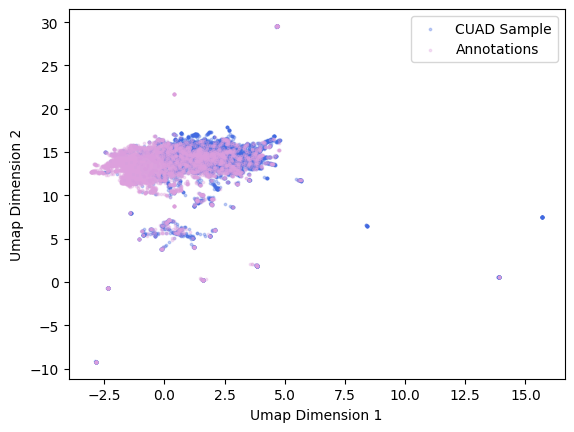

In [24]:
plot_comparison_corpora(OOS_sentences, sentence_embeddings, 'Embedding', sample_size=5000)

<br/>
Now, let's look at how well the rules work on our OOS dataset:
<br/>

In [25]:
print('Percent Annotations Captured by rules:', round(sum(OOS_annos['Text'].apply(lambda x: rule_search(x)))/len(OOS_annos)*100,2))
OOS_annos['Text'].apply(lambda x: rule_search(x))

Percent Annotations Captured by rules: 47.37


0     False
1      True
2     False
3      True
4      True
      ...  
71    False
72     True
73     True
74     True
75     True
Name: Text, Length: 76, dtype: bool

In [26]:
OOS_sentences['Rule_Results'] = OOS_sentences['sentence_text'].apply(lambda x: rule_search(x))

In [27]:
calculate_metrics(OOS_sentences, OOS_annos)

({'True Positives': 34,
  'False Negatives': 42,
  'True Negatives': 26966,
  'False Positives': 69},
 {'Accuracy': 0.9959, 'Precision': 0.3301, 'Recall': 0.4474})

<br/>

As may have been expected, our regular expression based rules do not extrapolate as well with new data outside of our original population. While accuracy is still high due to the large amount of true negatives, precision is still very low and recall has dropped about 15%.

Regular expressions work well for highly consistent data, but in many cases won't work nearly as well when there is variability in the corpus.

Given the results of our rule-based approach so far, we have a few options now. We could to spend time refining our rules to make them more specific and to improve performance. Or -- we can try a machine learning approach.



<br/>

### Exercise 6.3:

But first - one additional exercise. Leveraging your function from before, calculate the performance metrics at the document level for the out of sample documents.

How do these metrics compare to the in-sample metrics?

<br/>

<br/><br/><br/>

# 2. Machine Learning Approach

Now, let's take a more probabalistic approach by leveraging machine learning to better identify the right sentence in the document that discusses payment terms. We will start by building a sentence-level classifier with our sentence embeddings. 

With this approach, we can also limit false positives by selecting only the top probability sentence to per document.

In [28]:
ml_annotated_files = sentence_embeddings[sentence_embeddings['filename'].isin(payment_annos['Filename'])]
ml_neg_sample = ml_annotated_files[ml_annotated_files['Label']==0].sample(n=5000, random_state=1)
ml_pos_sample = ml_annotated_files[ml_annotated_files['Label']==1]
ml_sample = pd.concat((ml_neg_sample, ml_pos_sample))

<br/>

Now, what we've done above to create our sample is:
- Limit to our annotated documents
- Taken several thousand random samples of negative sentences
- Added our known positive annotated sentences

Why are we not doing additional selection of our sample? For instance, we could do further filtering to keep only sentences of a certain length, throwing out likely non-sensical / non-sentence examples like clause headings or junk like "Contract (PO) Number: 26568\n\n‘". Or, we could filter to only keep high quality OCR sentences, with a high percentage of words that are in the dictionary.

However, what would be the impact of this filtering on our model training process? If the model doesn't see these types of low-quality OCR or irrelevant, short sentences, it won't learn that these are negative examples of what we are looking for. It is valuable to leave these types of examples in the mix of our negative examples, since it will represent the range of what we will see "in the wild" when we are using these models at scale.

<br/>

In [29]:
X_train = []
for x in ml_sample[ml_sample['Dataset']=='Train']['Embedding'].values:
    X_train.append(x)

X_test = []
for x in ml_sample[ml_sample['Dataset']=='Test']['Embedding'].values:
    X_test.append(x)

y_train = ml_sample[ml_sample['Dataset']=='Train']['Label'].values
y_test = ml_sample[ml_sample['Dataset']=='Test']['Label'].values

In [30]:
[np.shape(a) for a in [X_train, X_test, y_train, y_test]]

[(4172, 384), (1120, 384), (4172,), (1120,)]

In [31]:
clf = GradientBoostingClassifier(n_estimators=150, random_state=1).fit(X_train, y_train)

In [32]:
y_pred_train = clf.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[3936    0]
 [   0  236]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3936
           1       1.00      1.00      1.00       236

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



In [33]:
y_pred_test = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, clf.predict(X_test)))

[[1062    2]
 [   6   50]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1064
           1       0.96      0.89      0.93        56

    accuracy                           0.99      1120
   macro avg       0.98      0.95      0.96      1120
weighted avg       0.99      0.99      0.99      1120



In [34]:
model_save_path = os.path.join(HOME_DIRECTORY, 'data', 'models')
model_name = 'ml_classifier_gbc.pkl'

with open(os.path.join(model_save_path, model_name), 'wb') as file:
        pickle.dump(clf, file)

<br/>

Now, we've built and tested a reasonably good model to retrieve the relevant sentences for payment terms. But, let's go one step further here and check the probabilities to see how strong the separation is between positive and negative examples.

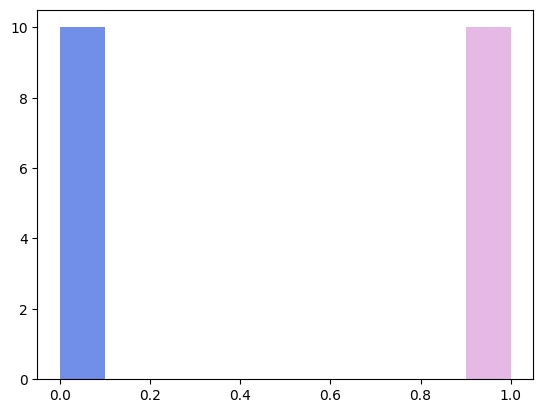

In [35]:
train_thresholds = pd.DataFrame([y_train, clf.predict_proba(X_train)[:,1]]).T
train_thresholds.columns = ['Label', 'Pred Probability']
test_thresholds = pd.DataFrame([y_test, clf.predict_proba(X_test)[:,1]]).T
test_thresholds.columns = train_thresholds.columns

plt.hist(train_thresholds[train_thresholds['Label']==0]['Pred Probability'], color='royalblue', alpha=0.75, bins=np.arange(0,1.1,.1), density=True);
plt.hist(train_thresholds[train_thresholds['Label']==1]['Pred Probability'], color='plum', alpha=0.75, bins=np.arange(0,1.1,.1), density=True);

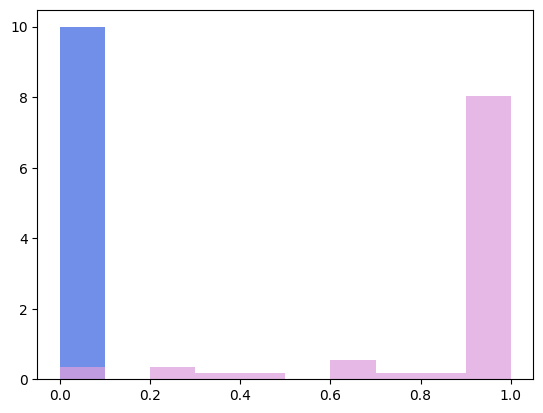

In [36]:
plt.hist(test_thresholds[test_thresholds['Label']==0]['Pred Probability'], color='royalblue', alpha=0.75, bins=np.arange(0,1.1,.1), density=True);
plt.hist(test_thresholds[test_thresholds['Label']==1]['Pred Probability'], color='plum', alpha=0.75, bins=np.arange(0,1.1,.1), density=True);

<br/>

### Exercise 6.4:

Explore using TF-IDF instead of embeddings as features. How do the sentence and document level metrics change? Why might this happen?

*(TF-IDF tips: remember to limit vocab size to avoid overfitting, use a small range of n-grams, and ignore very low and very high probability tokens)*

<br/>

<br/>

### Exercise 6.5:

Try an alternative supervised classification algorithm. Is there a statistically significant difference?

<br/>

<br/>

### Exercise 6.6:

Test changing the threshold for model predictions from the default of 0.5. How does this impact performance on the train and the test sets?

<br/>

<br/>

### **Machine Learning**: Document-Level Testing

Now, we have built a model to identify the context in the document discussing payment terms. However, we have only tested the performance on a sentence-by-sentence level. Now we need to evaluate if we can maintain a high level performance at a *document* level, where we are extracting the top probability sentence from each document.

We'll start by predicting the probability for each individual sentence, then pick the top per each document and compare to the real, annotated answer.

In [37]:
threshold = 0.5
ml_annotated_files['Probability'] = ml_annotated_files['Embedding'].apply(lambda x: clf.predict_proba([x])[0][1]);
ml_annotated_files['Predicted Label'] = ml_annotated_files['Probability'].apply(lambda x: 0 if x<threshold else 1);

/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/269179956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_annotated_files['Probability'] = ml_annotated_files['Embedding'].apply(lambda x: clf.predict_proba([x])[0][1]);
/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/269179956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_annotated_files['Predicted Label'] = ml_annotated_files['Probability'].apply(lambda x: 0 if x<threshold else 1);


In [38]:
doc_level_preds = ml_annotated_files.loc[ml_annotated_files.groupby('filename')["Probability"].idxmax()]
doc_level_preds.head()

,filename,sentence_index,sentence_text,Embedding,Label,Dataset,Rule_Results,Probability,Predicted Label
6454,00000JZM.pdf.txt,308,The City wil\nprocess the payment within 60 ca...,"[0.25620103, 0.11852089, -0.233818, -0.2146448...",1,Train,True,0.998688,1
69340,00000LRJ.pdf.txt,294,The City will process payment within 60 days a...,"[-0.12235852, -0.09604282, 0.036402386, -0.198...",1,Test,True,0.999777,1
445210,00000M8Z.pdf.txt,302,The City will process payment within 60 days a...,"[-0.107448906, -0.107014984, 0.010531411, -0.1...",1,Train,True,0.999809,1
680457,00000NB4.pdf.txt,332,INVOICES\n\n,"[-0.69768953, 0.052773457, -0.34449014, -0.564...",0,Train,False,0.969047,1
235983,00000NHB.pdf.txt,309,The City will process payment within 60 days a...,"[-0.12235852, -0.09604282, 0.036402386, -0.198...",1,Train,True,0.999777,1


In [39]:
print(confusion_matrix(doc_level_preds['Label'], doc_level_preds['Predicted Label']))
print(classification_report(doc_level_preds['Label'], doc_level_preds['Predicted Label']))

[[  0  40]
 [  1 251]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.86      1.00      0.92       252

    accuracy                           0.86       292
   macro avg       0.43      0.50      0.46       292
weighted avg       0.74      0.86      0.80       292



<br/>

Lucky for us, the top probability sentence for each document is also the annotated sentence in the majority of cases. An overall accuracy of 86% is pretty good to start, though we can make additional changes to the model and the data to continue to improve performance.

*Note: Remember that in this case, by design when assessing our annotated documents, we expect each document to have a **true** prediction (e.g. no negative cases). We will cover confirming negative predictions momentarily in the next section.*

<br/>

### Exercise 6.7:

Split the document level metrics into the train and test set. How do the metrics compare at the document level for the training and testing sets?

*Note that per best practices, we would typically look at both the sentence and document level training metrics as we iterate during development. Then, when ready, we would look at the sentence and document level metrics for the test set. The order is adjusted here for the sake of exercises.*

<br/>



<br/>

### Exercise 6.8:

Explore the incorrect predictions in the training and testing sets. Are these bad annotations, or did the model predict incorrectly? If the former, what is the cause (e.g. multiple authoritative sources in the document)? If the latter, why do you think that may be?

<br/>



<br/>
<br/>

Next, there are a few additional steps we need to do to check and validate performance:
1. Confirm performance on documents without any payment terms language
2. Check performance on an out of sample set of annotations to confirm reasonable extrapolation of the model

<br/>

#### **Machine Learning**: Confirming Negative Predictions

First, let's check performance on "negative" documents - cases where we know no payment terms language is present. We have provided a list of documents (via the Google drive) that do not have payment terms present, which we load below.

In [40]:
neg_files = pd.read_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_negative_docs.xlsx'))
                 
ml_negs = sentence_embeddings[sentence_embeddings['filename'].isin(neg_files['Filename'])]
ml_negs['Probability'] = ml_negs['Embedding'].apply(lambda x: clf.predict_proba([x])[0][1]);
ml_negs['Predicted Label'] = ml_negs['Probability'].apply(lambda x: 0 if x < threshold else 1);

idx_max_prob_per_filename = ml_negs.groupby('filename')['Probability'].idxmax()
top_rows_df = ml_negs.loc[idx_max_prob_per_filename]
negs_doc_level_preds = top_rows_df.reset_index(drop=True)

/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/1707978798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_negs['Probability'] = ml_negs['Embedding'].apply(lambda x: clf.predict_proba([x])[0][1]);
/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/1707978798.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_negs['Predicted Label'] = ml_negs['Probability'].apply(lambda x: 0 if x < threshold else 1);


<br/><br/>

Let's inspect the **false positive** predictions from these documents that do not have any payment terms language present:

In [41]:
negs_doc_level_preds[negs_doc_level_preds['Predicted Label']==1]

,filename,sentence_index,sentence_text,Embedding,Label,Dataset,Rule_Results,Probability,Predicted Label
17,00002V49.pdf.txt,22,The maximum compensation is increased from $30...,"[0.060176883, 0.4465544, 0.12068288, -0.031842...",0,Train,False,0.579256,1
86,{526DE1DD-FAB2-44CA-BBD8-500AFB030E53}.pdf.txt,287,Programs are required to operate a minimum of ...,"[0.62543714, -0.23115893, -0.17518792, -0.3102...",0,Train,False,0.672136,1
105,{FE20D4AB-BF71-4525-AE14-B5CE70748C8C}.pdf.txt,271,Programs are required to operate a minimum of ...,"[0.46179008, -0.07574048, -0.059909284, -0.032...",0,Train,False,0.731705,1


In [42]:
negs_doc_level_preds[negs_doc_level_preds['Predicted Label']==1]['sentence_text'].values

array(['The maximum compensation is increased from $30,000.00 to $40,000.00.',
       'Programs are required to operate a minimum of 5 days and 30 hours\n\n',
       'Programs are required to operate a minimum of $ days and 30 hours\n\n'],
      dtype=object)

<br/>

We only have 3 false positives out of 107 documents - that's a pretty low false positive rate of <3%, which is pretty good. 

As we can see from inspecting the false positives:
1. They are true false positives - it is always good to confirm we have not missed an annotation
2. Most have relatively lower probabilities than the general population of predictions, in the 0.5 to 0.75 range.

Although this is already quite good, how may we further improve these results? 

One option is to curate the negative examples we use in our machine learning model to allow the model to more clearly learn where the distinguishing line between the positive and negative classes lives. For example, we may run the model across a larger portion of the corpus to identify more cases where there is a false positive with high probability, and loop this back into training as negative examples.

Another option is to check and assess the threshold between classes. For example, we may look at the distribution of model prediction probabilities for those classified both correctly and incorrectly, and assess if a change in the default threshold (p=0.5) would make sense to improve performance overall (or, more specifically, the metric we care most about).

<br/>

#### **Machine Learning**: Full Document-Level Results

Now, let's combine our doc-level results for both positive and negative classes --

In [43]:
pos_and_neg = pd.concat((doc_level_preds, negs_doc_level_preds))
print(confusion_matrix(pos_and_neg['Label'], pos_and_neg['Predicted Label']))
print(classification_report(pos_and_neg['Label'], pos_and_neg['Predicted Label']))

[[104  43]
 [  1 251]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       147
           1       0.85      1.00      0.92       252

    accuracy                           0.89       399
   macro avg       0.92      0.85      0.87       399
weighted avg       0.90      0.89      0.88       399



<br/>

Overall, our results looking good! Let's move on to testing an out of sample set of data.

<br/><br/>

#### **Machine Learning**: Out of Sample Testing

Now, let's test how well our machine learning models perform on a totally new set of data -- this is the same data we leveraged for out of sample testing for our rules (the CUAD dataset).

In [44]:
threshold = 0.5
ml_oob_annotated_files = OOS_sentences[OOS_sentences['filename'].isin(OOS_annos['Filename'])]
ml_oob_annotated_files['Probability'] = ml_oob_annotated_files['Embedding'].apply(lambda x: clf.predict_proba([x])[0][1]);
ml_oob_annotated_files['Predicted Label'] = ml_oob_annotated_files['Probability'].apply(lambda x: 0 if x<threshold else 1);

/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/1317929236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_oob_annotated_files['Probability'] = ml_oob_annotated_files['Embedding'].apply(lambda x: clf.predict_proba([x])[0][1]);
/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_15220/1317929236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_oob_annotated_files['Predicted Label'] = ml_oob_annotated_files['Probability'].apply(lambda x: 0 if x<threshold else 1);


In [45]:
oob_doc_level_preds = ml_oob_annotated_files.loc[ml_oob_annotated_files.groupby('filename')["Probability"].idxmax()]
print(confusion_matrix(oob_doc_level_preds['Label'], oob_doc_level_preds['Predicted Label']))
print(classification_report(oob_doc_level_preds['Label'], oob_doc_level_preds['Predicted Label']))

[[ 0 15]
 [ 1 48]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.76      0.98      0.86        49

    accuracy                           0.75        64
   macro avg       0.38      0.49      0.43        64
weighted avg       0.58      0.75      0.66        64



<br/>

As expected, we see an overall performance drop when we run our model on the out of sample documents, down to overall 75% accuracy, largely due to false negative predictions.

*Note: Again, remember that in this case, by design when assessing our annotated out-of-sample documents, we expect each document to have a true prediction (e.g. no negative cases). Exercise 6.11 covers including negative cases in the overall metrics.*

<br/>

### Exercise 6.9:

Explore the false negatives - is there something unique about these examples that we are not capturing in our annotated dataset? If so, what are our next steps to improve the model's ability to extrapolate? (e.g. do we need to revisit our seeds for semantic search?) 

<br/>

<br/>

### Exercise 6.10:

Find documents in our out of sample set that do not have payment terms language, and calculate a false positive rate. Combine the document-level metrics for positive and negative documents to calculate overall performance on the out-of-sample population.

<br/>

<br/>

### Exercise 6.11:

Combine the regular expressions with the machine learning model. How does this impact performance overall on the train, test, and out-of-sample datasets?

<br/>

<br/><br/>

#### **Machine Learning**: Comparative Performance of Random Annotations vs Targeted Annotations

As discussed in the book, it's important to think critically about what data gets labeled for two purposes:
1. Maximize the variability in the dataset to more quickly optimize model performance and generalizability
2. Make the most of your subject matter experts' time in reviewing and labeling ground truth data

Both these items are true regardless of the technical approach that is being adopted, and so it's worth taking a look at what happens when we don't think critically about our ground truth data. Here, we'll use a set of randomly selected dat that was annotated, and see how it impacts ML performance.

In [46]:
## Load randomly selected payment terms annotations
payment_random_all = pd.read_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_random_sample-annotated.xlsx'), engine='openpyxl')

### Convert to embeddings
payment_random_all['Embedding'] = payment_random_all['Text'].apply(lambda t: sent_emb_model.encode(t))

### Remove false positives
payment_random = payment_random_all[payment_random_all['Answer']!='FALSE POSITIVE']

### Check
payment_random[['Filename', 'Text', 'Answer']].head()

,Filename,Text,Answer
0,d203747dex1015.html,6.3 Unless otherwise agreed in writing by\nthe...,30
1,pinstripesdistributionag.html,The Customer agrees to pay such invoices withi...,30
2,spar ex99-1.htm,● All\n ...,30
3,a20240630ex103consultingag.html,Payment terms: net 30 days from receipt of inv...,30
4,cbll-ex10_28.html,The Company will remit payment for properly su...,30


In [47]:
ml_annotated_files_random = sentence_embeddings[sentence_embeddings['filename'].isin(payment_random['Filename'])]
ml_neg_sample_random = ml_annotated_files_random[ml_annotated_files_random['Label']==0].sample(n=5000, random_state=1)
ml_pos_sample_random = ml_annotated_files_random[ml_annotated_files_random['Label']==1]
ml_sample_random = pd.concat((ml_neg_sample_random, ml_pos_sample_random))

In [54]:
X_train_random = []
for x in ml_sample_random[ml_sample_random['Dataset']=='Train']['Embedding'].values:
    X_train_random.append(x)

X_test_random = []
for x in ml_sample_random[ml_sample_random['Dataset']=='Test']['Embedding'].values:
    X_test_random.append(x)

y_train_random = ml_sample_random[ml_sample_random['Dataset']=='Train']['Label'].values
y_test_random = ml_sample_random[ml_sample_random['Dataset']=='Test']['Label'].values

In [55]:
clf = GradientBoostingClassifier(n_estimators=150, random_state=1).fit(X_train_random, y_train_random)

In [56]:
y_pred_train_random = clf.predict(X_train_random)
print(confusion_matrix(y_train_random, y_pred_train_random))
print(classification_report(y_train_random, y_pred_train_random))

[[4000    0]
 [   0   47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00        47

    accuracy                           1.00      4047
   macro avg       1.00      1.00      1.00      4047
weighted avg       1.00      1.00      1.00      4047



In [57]:
y_pred_test_random = clf.predict(X_test_random)
print(confusion_matrix(y_test_random, y_pred_test_random))
print(classification_report(y_test_random, clf.predict(X_test_random)))

[[998   2]
 [  2   5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       0.71      0.71      0.71         7

    accuracy                           1.00      1007
   macro avg       0.86      0.86      0.86      1007
weighted avg       1.00      1.00      1.00      1007



<br/>

As we can see, a randomly selected set looks to perform great on the training set, but fails to generalize nearly as well on the test set compared to our prior curated train and test datasets that were annotated. 

Because we have not thoughtfully ensured that our training and testing sets captures the variability of the underlying population, the model does not generalize as well.

Even if we are not training a supervised model, it is still critical to ensure our curated datasets contain a wide swath of the variability in the corpus. If not, we will be developing rules or prompt engineering on a dataset that does not represent the variety of language we may see in the corpus. This is especially important if we have a corpus that has a big chunk of similar data but a long tail of variability.

<br/><br/>

<br/>

### Exercise 6.12:

Test the model built on the random sample on the out-of-sample dataset. How do the OOS performances compare? Explain the reasons this may be the case.

<br/>

<br/><br/><br/>

# 3. GenAI RAG with LLM Approach

Now we move on to our final technique for this problem - leveraging semantic retrieval combined with a large language model to identify the correct context for payment terms.

This requires two steps in our modeling process:
1. Identify relevant payment terms candidates contexts based on semantic similarity
2. Assess top candidates using LLM and return a well-structured response

As part of step 2, we will need to do some iterative prompt engineering and assess against our training set to evaluate performance.

**Note**: This section requires that the user set up an API key through OpenAI to use in the following code. We recommend starting with the OpenAI [quickstart guide](https://platform.openai.com/docs/quickstart) or the [API documentation](https://platform.openai.com/docs/api-reference/introduction). Once the key is set up, we recommend adding it to a .env file on your local instance of the repo. Alternatively, the user can set up an alternative LLM API and key, if preferred, and adjust the code in this section accordingly.

<br/>

We'll load in an existing key that has been set up in the .env file, which we'll use for the below section:

In [58]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

<br/>

Next, let's create a few functions that will let us create a prompt and send to the API:

In [59]:
def send_openai_request(prompt, openapi_key, model="gpt-5-mini-2025-08-07", temperature=0.0, max_tokens=1000):
  """
  Sends a request to the OpenAI API with the provided prompt and returns the response.

  Args:
      prompt: The text prompt to send to the OpenAI API.
      openapi_key: API key set up to access OpenAI API.
      model: The OpenAI model to use (default: "gpt-5-mini-2025-08-07").
      temperature: Controls the randomness of the generated text (default: 0.0).
      max_tokens: The maximum number of tokens to generate in the response (default: 1000).

  Returns:
      A dictionary containing the API response, including the generated text and other details.
  """  

  try:
    client = OpenAI(api_key = openapi_key)
    completion = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        # temperature = temperature,
        messages=[
            {"role": "system", "content": "You are a legal expert doing your best to interpret text from a contract document."},
            {"role": "user", "content": prompt},
        ]
    )
    return completion.choices[0].message.content
  except openai.error.OpenAIError as e:
    raise Exception(f"Error communicating with OpenAI API: {e}")

def construct_prompt(retrieved_sentences, indices):
    'Uses pre-set instructions to embed the retrieved sentence and create a prompt for each API request and assesses the top 3 sentences only'
    
    prompt = '''You are a legal expert, doing your best to accurately interpret legal clauses and text. Your task is to interpret the language below to identify whether the text is "Yes" discussing payment terms or "No" discussing some other topic. Payment terms are the conditions set by businesses regarding when payments should be made for goods or services, specifically the number of days a buyer has to submit their payment. For example, "Net 30" means the buyer has 30 days to pay.

Evaluate three sentences that are potentially relevant to payment terms. Assess which one is most likely referring to the payment terms and provide a response that gives the following information:
    1. Context: the sentence that is most likely discussing payment terms from the examples; pick only one sentence and return as-is verbatim. If none, return "Null",
    2. Index: the numerical, integer index that is associated to the context sentence, which is provided for each potential context
    3. Payment Terms: an integer value indicating the number of days, e.g. "30" or "60". If payment terms is not an integer (such as "as soon as possible" or other non-integer value) return the relevant text. If none, return "Null"

Provide your response in the specified json format below:
    {'Context': <selected sentence most relevant to payment terms or Null>, 
    'Index': <index that corresponds to selected sentence>
    'Payment Terms': <integer value or Null>}

Examples to interpret: 
    1. Index = '''+str(indices[0])+''', "''' + retrieved_sentences[0] + '''"
    2. Index = '''+str(indices[1])+''', "''' + retrieved_sentences[1] + '''"
    3. Index = '''+str(indices[2])+''', "''' + retrieved_sentences[2] + '''"
    '''

    return prompt

<br/>

And now we'll test that with a dummy example:

In [60]:
test_sentence = ['Invoices must be sent to the mailing address above in order to be paid.',
                 'The City will process invoices for payment within sixty days after receipt.', 
                 'Contractor will raise any issues or complaints about invoices within 90 days or be charged a late fee.']

prompt = construct_prompt(test_sentence, [1234, 86754, 99876])
print(prompt)

You are a legal expert, doing your best to accurately interpret legal clauses and text. Your task is to interpret the language below to identify whether the text is "Yes" discussing payment terms or "No" discussing some other topic. Payment terms are the conditions set by businesses regarding when payments should be made for goods or services, specifically the number of days a buyer has to submit their payment. For example, "Net 30" means the buyer has 30 days to pay.

Evaluate three sentences that are potentially relevant to payment terms. Assess which one is most likely referring to the payment terms and provide a response that gives the following information:
    1. Context: the sentence that is most likely discussing payment terms from the examples; pick only one sentence and return as-is verbatim. If none, return "Null",
    2. Index: the numerical, integer index that is associated to the context sentence, which is provided for each potential context
    3. Payment Terms: an integ

In [61]:
response = send_openai_request(prompt, OPENAI_API_KEY)
print(response)

{  
 	"Context": "The City will process invoices for payment within sixty days after receipt.",  
 	"Index": 86754,  
 	"Payment Terms": 60  
}


<br/><br/>

Now that we have the functionality set up for the prompt and LLM API call, let's also set up a semantic retrieval step. We'll set this up to pull the top three candidates from each document, and these three candidates will get automatically fed into the prompt for the LLM to assess.

Passing the top three candidates is a strategic decision - we expect if we only use the top semantic search result, we will likely get more incorrect. By passing the additional candidates to the LLM, we expect to increase our overall performance by not relying solely on the retrieval step to get the correct context:

In [62]:
def get_ranked_nn_for_examples(search_texts, u, sent_emb_model=sent_emb_model):
    ranked_nn_array = []
    example_embeds = []
    for n, s in enumerate(search_texts):
        emd_new = sent_emb_model.encode(s)
        example_embeds.append(emd_new)
        ranked_nn = u.get_nns_by_vector(emd_new, u.get_n_items())
        ranked_nn_array.append(ranked_nn)
    return ranked_nn_array, example_embeds

def get_combined_sorted_nn(ranked_nn_array, file_indices, example_embeds, u):
    df = pd.DataFrame()
    for n, ranked_nn in enumerate(ranked_nn_array):
        sorted_file_indices = []
        sorted_distances = []
        for i in ranked_nn: ## loop through entire list of sorted NN - repeated for each search example
            if i in file_indices:
                sorted_file_indices.append(i) ### in order of increasing distance from search
                sorted_distances.append(math.dist(example_embeds[n], u.get_item_vector(i)))
    
        tmp = pd.DataFrame([[n]*len(sorted_file_indices), sorted_file_indices, sorted_distances]).T
        df = pd.concat((df, tmp))
    df.columns = ['Example ID', 'Index', 'Distance']
    df = df.sort_values('Distance').drop_duplicates(subset=['Index'], keep='first')
    return df

def retrieve_sentences_per_doc(search_texts, annotated_files, annoy_database_filepath,
                               embedding_model, top_n=3, vec_len=384):
    u = AnnoyIndex(vec_len, 'angular')
    u.load(annoy_database_filepath)

    db_len = u.get_n_items()
    ranked_nn_array, example_embeds = get_ranked_nn_for_examples(search_texts, u, sent_emb_model=embedding_model)

    candidate_texts = []; candidate_indices = []
    for f in annotated_files:
        file_indices = sentence_embeddings[sentence_embeddings['filename'] == f].index.values
        df = get_combined_sorted_nn(ranked_nn_array, file_indices, example_embeds, u)
        candidate_text = [sentence_embeddings[sentence_embeddings.index==i]['sentence_text'].values[0] 
                           for i in df['Index'].values[:top_n]]
        candidate_texts.append(candidate_text)
        candidate_indices.append(df['Index'].values[:top_n])
    return candidate_texts, candidate_indices

def get_results_from_openai(annotated_files, candidate_texts, candidate_indices):
    """
    Processes annotated files by sending prompts to the OpenAI API, handling JSON parsing errors.

    Args:
        annotated_files (list): List of filenames.
        candidate_texts (list): List of text candidates.
        candidate_indices (list): List of candidate indices.

    Returns:
        pandas.DataFrame: A DataFrame containing the filename, prompt, and parsed API response.
    """
    df = pd.DataFrame()
    for i, f in enumerate(annotated_files):
        prompt = construct_prompt(candidate_texts[i], candidate_indices[i])
        
        # Initial attempt and retry loop for API call and JSON parsing
        success = False
        retry_count = 0
        while not success and retry_count < 3:  # Retry up to 3 times
            try:
                response = send_openai_request(prompt, OPENAI_API_KEY)
                data = json.loads(response)
                context = data['Context']
                sent_ind = data['Index']
                terms = data['Payment Terms']
                
                tmp = pd.DataFrame([[f, prompt, sent_ind, context, terms]], 
                                   columns=['Filename', 'Prompt', 'Sent_Index', 'Context', 'Payment Terms'])
                df = pd.concat((df, tmp))
                success = True
            except json.JSONDecodeError as e:
                print(f"JSON decoding failed for file {f}: {e}. Retrying... (Attempt {retry_count + 1})")
                retry_count += 1
                time.sleep(1) # Wait for 1 second before retrying
            except Exception as e:
                print(f"An unexpected error occurred for file {f}: {e}.")
                break # Exit the retry loop for other types of errors
        
        if not success:
            print(f"Failed to process file {f} after multiple retries. Skipping...")
            # Optionally, log or handle the failure case here, e.g., by adding an empty row
            # tmp = pd.DataFrame([[f, prompt, None, None, None]], 
            #                    columns=['Filename', 'Prompt', 'Sent_Index', 'Context', 'Payment Terms'])
            # df = pd.concat((df, tmp))

    df.reset_index(drop=True, inplace=True)
    return df

<br/><br/>

Now let's set up and run through our set of train and test documents with our GenAI RAG approach.

*Note: For reference, at current token input and output costs for GPT-5 mini as of summer 2025, the cost to run through 280 documents is less than one dollar*.

In [64]:
payment_search_texts = [
    '''Invoices are to be submitted monthly in arrears, after services have been completed, to the address specified below. Payment
    will be net thirty (30) days after receipt of an invoice in a format acceptable to Customer, as applicable.''',
    '''Supplier agrees to pay customer the undisputed amount of an invoice within ninety (90) days after the date of a valid,
    complete and properly documented invoice.''',
    '''Unless otherwise noted, the buyer has sixty (60) days to pay invoice, as allowed by section 4.3.''',
               ]
annotated_filenames = payment_annos['Filename'].values
annoy_database_filepath = os.path.join(HOME_DIRECTORY, 'data', 'annoy_indices', 'corpus_annoy_db.ann')

candidate_texts, candidate_indices = retrieve_sentences_per_doc(payment_search_texts, annotated_filenames,
                           annoy_database_filepath, sent_emb_model)
results = get_results_from_openai(annotated_filenames, candidate_texts, candidate_indices)

results.head()

,Filename,Prompt,Sent_Index,Context,Payment Terms
0,tm2421105d1_ex10-1.htm,"You are a legal expert, doing your best to acc...",796139.0,Payment of invoices submitted for Services wil...,30
1,tm2022502d7_ex10-1.htm,"You are a legal expert, doing your best to acc...",817242.0,Except as the applicable Provider and Recipien...,30
2,d203747dex1015.html,"You are a legal expert, doing your best to acc...",902124.0,6.3 Unless otherwise agreed in writing by\nthe...,30
3,pinstripesdistributionag.html,"You are a legal expert, doing your best to acc...",856859.0,The Customer agrees to pay such invoices withi...,30
4,spar ex99-1.htm,"You are a legal expert, doing your best to acc...",876506.0,● All\n ...,30


<br/><br/>

Now that we have our code set up, let's assess overall performance at the document level on the train and test sets:

In [73]:
genai_results = payment_annos.merge(results, left_on=['Filename', 'Index'], right_on=['Filename', 'Sent_Index'], how='left')

## We'll add a column to indicate if we got the prediction correct based on sentence index
genai_results['GenAI_Pred'] = genai_results['Index'] == genai_results['Sent_Index']

genai_results.head()

,Filename,Index,Cosine Similarity,Text,Embedding,Answer,Comment,Dataset,Prompt,Sent_Index,Context,Payment Terms,GenAI_Pred
0,tm2421105d1_ex10-1.htm,796139,0.826294,Payment of invoices submitted for Services wil...,"[-0.11684367, -0.26367605, -0.073101826, -0.44...",30,NaN,Train,"You are a legal expert, doing your best to acc...",796139.0,Payment of invoices submitted for Services wil...,30,True
1,tm2022502d7_ex10-1.htm,817242,0.813836,Except as the applicable Provider and Recipien...,"[-0.05047658, 0.05360353, -0.1944103, -0.06838...",30,NaN,Test,"You are a legal expert, doing your best to acc...",817242.0,Except as the applicable Provider and Recipien...,30,True
2,d203747dex1015.html,902124,0.801718,6.3 Unless otherwise agreed in writing by\nthe...,"[0.10877664, 0.02559523, -0.09234309, -0.09299...",30,NaN,Train,"You are a legal expert, doing your best to acc...",902124.0,6.3 Unless otherwise agreed in writing by\nthe...,30,True
3,pinstripesdistributionag.html,856859,0.799900,The Customer agrees to pay such invoices withi...,"[-0.06774448, -0.07578221, -0.23484963, -0.350...",30,NaN,Test,"You are a legal expert, doing your best to acc...",856859.0,The Customer agrees to pay such invoices withi...,30,True
4,spar ex99-1.htm,876506,0.797764,● All\n ...,"[-0.17738397, -0.064912, 0.049998436, -0.23613...",30,NaN,Train,"You are a legal expert, doing your best to acc...",876506.0,● All\n ...,30,True


<br/><br/>

Since these are all our positive annotations, let's do a quick check on accuracy:

In [74]:
for ds in ['Train', 'Test']:
    print(ds, 'set # right:', 
          sum(genai_results[genai_results['Dataset']==ds]['GenAI_Pred']))
    print(ds, 'set # wrong:', 
          len(genai_results[genai_results['Dataset']==ds]) - sum(genai_results[genai_results['Dataset']==ds]['GenAI_Pred']))
    print(ds, 'set accuracy:', 
          round(100*(sum(genai_results[genai_results['Dataset']==ds]['GenAI_Pred'])/len(genai_results[genai_results['Dataset']==ds])), 1),'%')
    print('\n')

Train set # right: 174
Train set # wrong: 60
Train set accuracy: 74.4 %


Test set # right: 42
Test set # wrong: 16
Test set accuracy: 72.4 %




</br></br>

In the remaining exercises for this section, we'll go through some of the same steps to assess and compare our results with a GenAI RAG approach to the other approaches.

<br/>

### Exercise 6.13:

Test this GenAI RAG approach on some of our negative document examples from the machine learning approach section. How well does the LLM perform on documents without payment term language, and can it properly differentiate between relevant and irrelevant context? Does the LLM have a bias towards non-null results?

<br/>

<br/>

### Exercise 6.14:

Try out some additional prompt engineering techniques. Are there methods you can take to improve overall performance?

<br/>

<br/>

### Exercise 6.15:

Check the document-level performance on the out-of-sample annotations with our GenAI RAG approach. Is it comparable to our other approaches? 

<br/>

<br/>

### Exercise 6.16:

- What is the document level performance for the parsing of the actual number of days (e.g. 30, 60) for this approach? 
- Does this "compound" model performance differ at all from the performance for retrieving and analyzing the correct sentence? 
- What does this indicate about the importance of these two separate pieces (retrieval vs understanding days) of the solution?

<br/>

<br/>

### Exercise 6.17:

Explore the cases where the retrieval augmented generation approach was incorrect. Are these similar to the cases that the other approaches got incorrect? Why might that be? 

<br/>

<br/>

### Exercise 6.18:

What happens if we test another LLM model instead? Are the results similar?

<br/>

<br/>

### Exercise 6.19:

Take the same three approaches for the limitation of liability field. How well does each of the three approaches work? What are some of the challenges with this field that are different from the payment terms field?

<br/>

<br/><br/><br/>

# Next Steps

While we have worked through many of the key components of data gathering, ingestion, pre-processing, exploration, dataset curation, and modeling, our journey is not yet done! 

Please continue to follow the [remaining steps and exercises](../) in the repo to complete the code companion with an end-to-end processing script, appropriate unit tests, documentation, model card, and more.

<br/><br/>